In [10]:
import mahotas as mh, random
import numpy as np, matplotlib
from matplotlib import pyplot as plt
from skimage.filters import rank
from skimage.morphology import disk
from skimage.feature import peak_local_max
import numpy as np, scipy.ndimage as ndi
import cv2
matplotlib.rcParams['figure.figsize'] = (5, 5)
plt.gray()

<Figure size 360x360 with 0 Axes>

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

stack image shape: (2048, 2048)


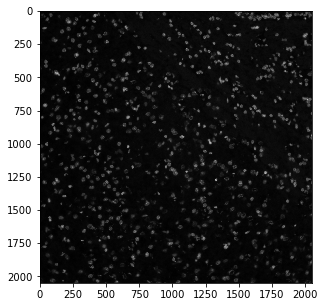

In [13]:
dna = plt.imread(r'C:\Users\Mo\OneDrive\Notes\OBI\CV-Images\Images_Data\DL_CellSeg\Mouse_DAPI\BA85_DAPI.tif'); 
print('stack image shape:',dna.shape)
dna_max = mh.stretch(dna);  plt.imshow(dna_max)

<b> Thresholding & filter

Otsu intensity: 36
Mean Intensity 13.950571537017822
Number of objects: 864


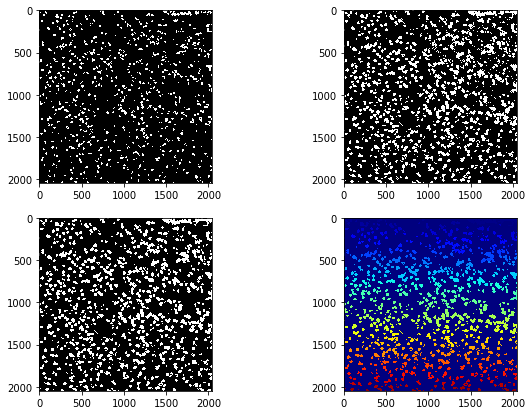

In [10]:
plt.figure(figsize=(10,7));
# Threshold 1 
T_otsu = mh.otsu(dna_max); print('Otsu intensity:',T_otsu)
plt.subplot(221); plt.imshow(dna_max > T_otsu)
# Threshold 2: mean
T_mean = dna_max.mean(); print('Mean Intensity',T_mean)
plt.subplot(222); plt.imshow(dna_max>T_mean)

# very noisy around the edges, but we can add some Gaussian blurring
dnaf = mh.gaussian_filter(dna_max, 2.)
T_mean = dnaf.mean(); bin_image = dnaf > T_mean
plt.subplot(223); plt.imshow(bin_image)

# label the image in order to assign index to each component
labeled, nr_object = mh.label(bin_image); print('Number of objects:',nr_object)
plt.subplot(224); plt.imshow(labeled); plt.jet()

In [11]:
filtered_img = mh.stretch(bin_image*dna_max)

### Separating touching cells
The general strategy we can use to separate the cells is the following:

1. Smooth the image with a Gaussian filter (we need to specify the  $\sigma$ parameter)
2. Find regional maxima on this smoothed image to identify each cell
3. Use watershed on the distance transformed image to separate cells.

Notes to myself:
* Always: blur radius < smallest radius of smallest cell on the image; 
<b> otherwise, loss of information

In [12]:
target = filtered_img
@interact(blur_factor=(0,50,1), sigma=(0.2, 3, 0.1), dil4show = (1,30,1))
def Blurg_maximas(blur_factor=13, sigma=0.5, dil4show = 20):    # dilf: dilate factor
    fig = plt.figure(figsize=(12,5)); fig.tight_layout(); 
    gaussian_f = mh.gaussian_filter(target, sigma = sigma); g_fitler = gaussian_f>gaussian_f.mean()
    ax1 = fig.add_subplot(131); ax1.imshow(target*g_fitler); ax1.set_title('gaussian')
    
    img_blurred= rank.mean(target, disk(blur_factor)); 
    plt.subplot(132); plt.imshow(img_blurred); plt.title('Blurred')
    gaussian_f = mh.gaussian_filter(img_blurred, sigma = sigma); 
    blurg_filter = gaussian_f>gaussian_f.mean(); filtered_img = img_blurred*blurg_filter;
    # Maximas
    maxima = mh.regmax(filtered_img,); 
    maxima_labeled, _ = mh.label(maxima);
    ax2 = fig.add_subplot(133); ax2.imshow(filtered_img); ax2.set_title('Blur then Gaussian (filtered_img)')
    plt.imshow(mh.as_rgb(np.maximum(255*mh.dilate(maxima,np.ones((dil4show,dil4show))), filtered_img), filtered_img, filtered_img > T_mean))
    return g_fitler, img_blurred, blurg_filter, filtered_img, maxima_labeled

interactive(children=(IntSlider(value=13, description='blur_factor', max=50), FloatSlider(value=0.5, descripti…

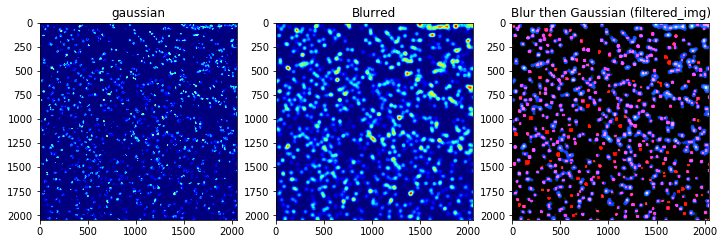

In [53]:
_,_, blurg_filter, filtered_img, maxima_labeled = Blurg_maximas(blur_factor=22,sigma=0.5)

Now, we compute the distance transform. Again, this is a single call, mh.distance

Because of the way that the watershed function is defined in mahotas, we need to invert the distance transform. Also, for technical reasons, we convert to uint8.

Finally, we can call mh.cwatershed with the dist image and the maxima as seeds.

In [40]:
# QC Functions: methods
def Label_sampler(labeled_objects, xy = 8, num_labels = 100):
    fig = plt.figure(figsize=(5*xy,5*xy)); start = random.randint(1, num_labels-xy**2)
    for n, i in enumerate(range(start, start+xy**2)):
        ax = fig.add_subplot(xy, xy,n+1)
        ax.imshow(labeled_objects==i)
        
# Filter Watershed label by size
from skimage.measure import regionprops
import matplotlib.patches as mpatches
def Label_boxer(labeled_objects, min_size = 20, max_size = None, area_record = False):
    fig, ax = plt.subplots(1,1, figsize=(8,8)); ax.imshow(labeled_objects)
    box_coords = {}; area_records = {}
    if not max_size:
        max_size = np.inf
    for region in regionprops(labeled_objects):
        area = region.area; label = region.label
        if min_size > area or area > max_size:
            continue
        minr, minc, maxr, maxc = region.bbox
        box_coords[label] = (minr, minc, maxr, maxc)   # Record the region
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=0.7)
        ax.add_patch(rect)
        area_records[label] = area
    if area_record:
        return box_coords, area_records
    else:
        return box_coords

<b> Watershed Option 1:

In [31]:
from skimage.morphology import watershed, disk

In [32]:
# With Mahotas
def Segmentation_by_maxi2(bin_image, seeds):
    dist = mh.distance(filtered_img)
    dist = dist.max() - dist; dist -= dist.min()
    dist = (dist/float(dist.ptp())*255)astype(np.uint8)
    
    plt.figure(figsize=(15,4))
    plt.subplot(131); plt.imshow(seeds)
    plt.subplot(132); plt.imshow(dist)
    seeds = maxima_labeled
    nuclei, lines = mh.cwatershed(dist, seeds,return_lines= True)*bin_image
    plt.subplot(133); plt.imshow(nuclei)
    Label_boxer(nuclei)
    return nuclei, lines

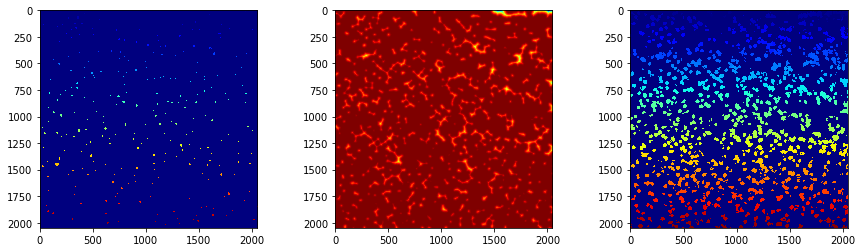

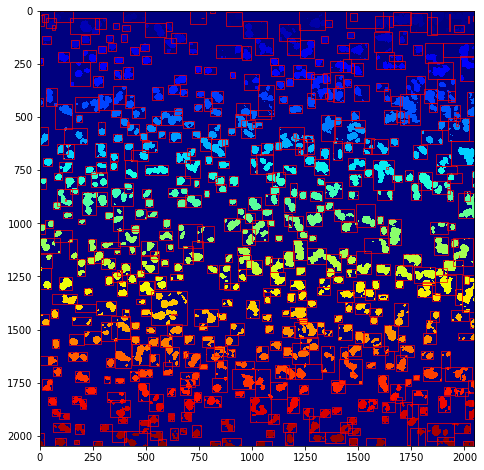

In [33]:
watershed_filter1, lines = Segmentation_by_maxi2(bin_image, maxima_labeled)

<b> Watershed Option 2

In [41]:
from skimage.morphology import watershed, disk

Notes to myself:
* Ideal: Footprint size < smallest distance between 2 maximas in the given image; <b>Otherwise, information loss

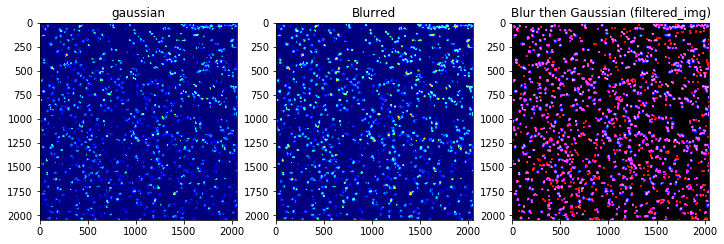

In [50]:
# need to use lower blur for maxi to be located
_,_, blurg_filter, filtered_img, maxima_labeled = Blurg_maximas(blur_factor=5,sigma=0.5)

In [54]:
mask = blurg_filter   # Choose which filter
@interact(footprint=(1,50,1))   # Important parameter
def Segmentation_by_maxi(footprint = 8):
    # Generate maximas
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint, footprint)), labels=mask, 
                               threshold_rel=10)
    markers = ndi.label(maxima_labeled)[0];    # Your maximas here
    #markers = maxima_labeled
    labels = watershed(-distance, markers, mask=mask); Label_boxer(labels)
    print('Number of objects detected: ', markers.max())
    fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True); fig.tight_layout(); ax = axes.ravel()
    ax[0].imshow(local_maxi, cmap=plt.cm.gray); ax[0].set_title(' objects')
    ax[1].imshow(-distance, cmap=plt.cm.gray); ax[1].set_title('Distances'); 
    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral); ax[2].set_title('Separated objects')
    return labels, local_maxi

interactive(children=(IntSlider(value=8, description='footprint', max=50, min=1), Output()), _dom_classes=('wi…

Number of objects detected:  597


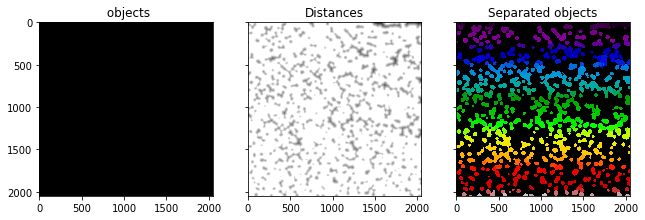

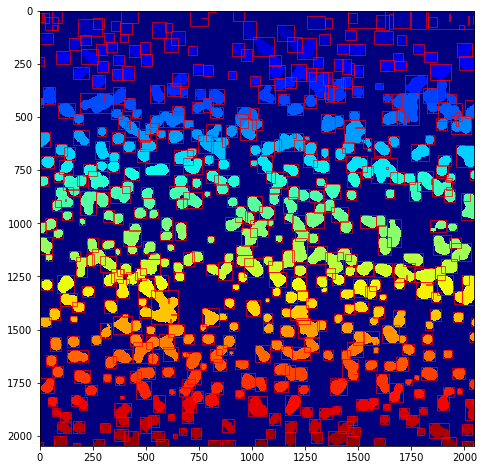

In [56]:
watershed_filter2 = Segmentation_by_maxi(6)

Interim QC

In [46]:
# Choose watershed labels: option 1 vs 2
watershed_labels = watershed_filter1
# Directly set it as final label if ideal
#final_labels = watershed_filter1

### Cleaning up regions
Remove cells touching the border <b>(Optional)</b>:

Number of objects 553


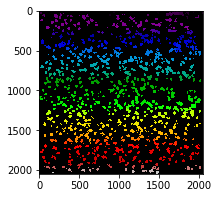

In [47]:
watershed_labels = mh.labeled.remove_bordering(watershed_labels);
print('Number of objects', len(np.unique(watershed_labels)))
plt.imshow(watershed_labels, cmap=plt.cm.nipy_spectral)

<b>(Neccessary)</b> remove things that are too small to be a cell

In [58]:
sizes = mh.labeled.labeled_size(watershed_labels);
@interact(min_size = (0,1000,10))
def size_filter(min_size = 500):
    print("filtering {}...".format(min_size))
    labels = mh.labeled.remove_regions_where(watershed_labels, sizes < min_size)
    print('Number of objects',len(np.unique(labels)))
    plt.figure(figsize=(10,8)); plt.imshow(labels, cmap = plt.cm.nipy_spectral)
    return labels

interactive(children=(IntSlider(value=500, description='min_size', max=1000, step=10), Output()), _dom_classes…

filtering 150...
Number of objects 529


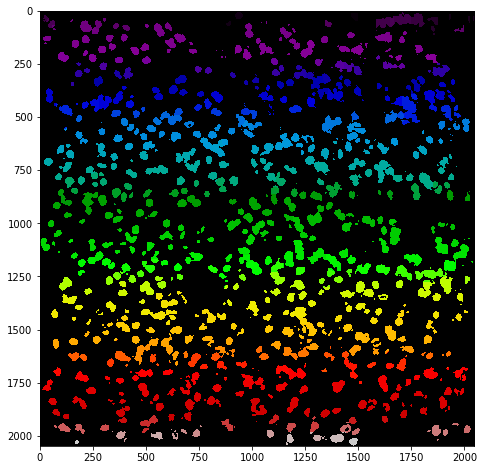

In [60]:
final_labels = size_filter(150)

<b> (X) Filling holes & touching objects (X) 

<b> Final QC

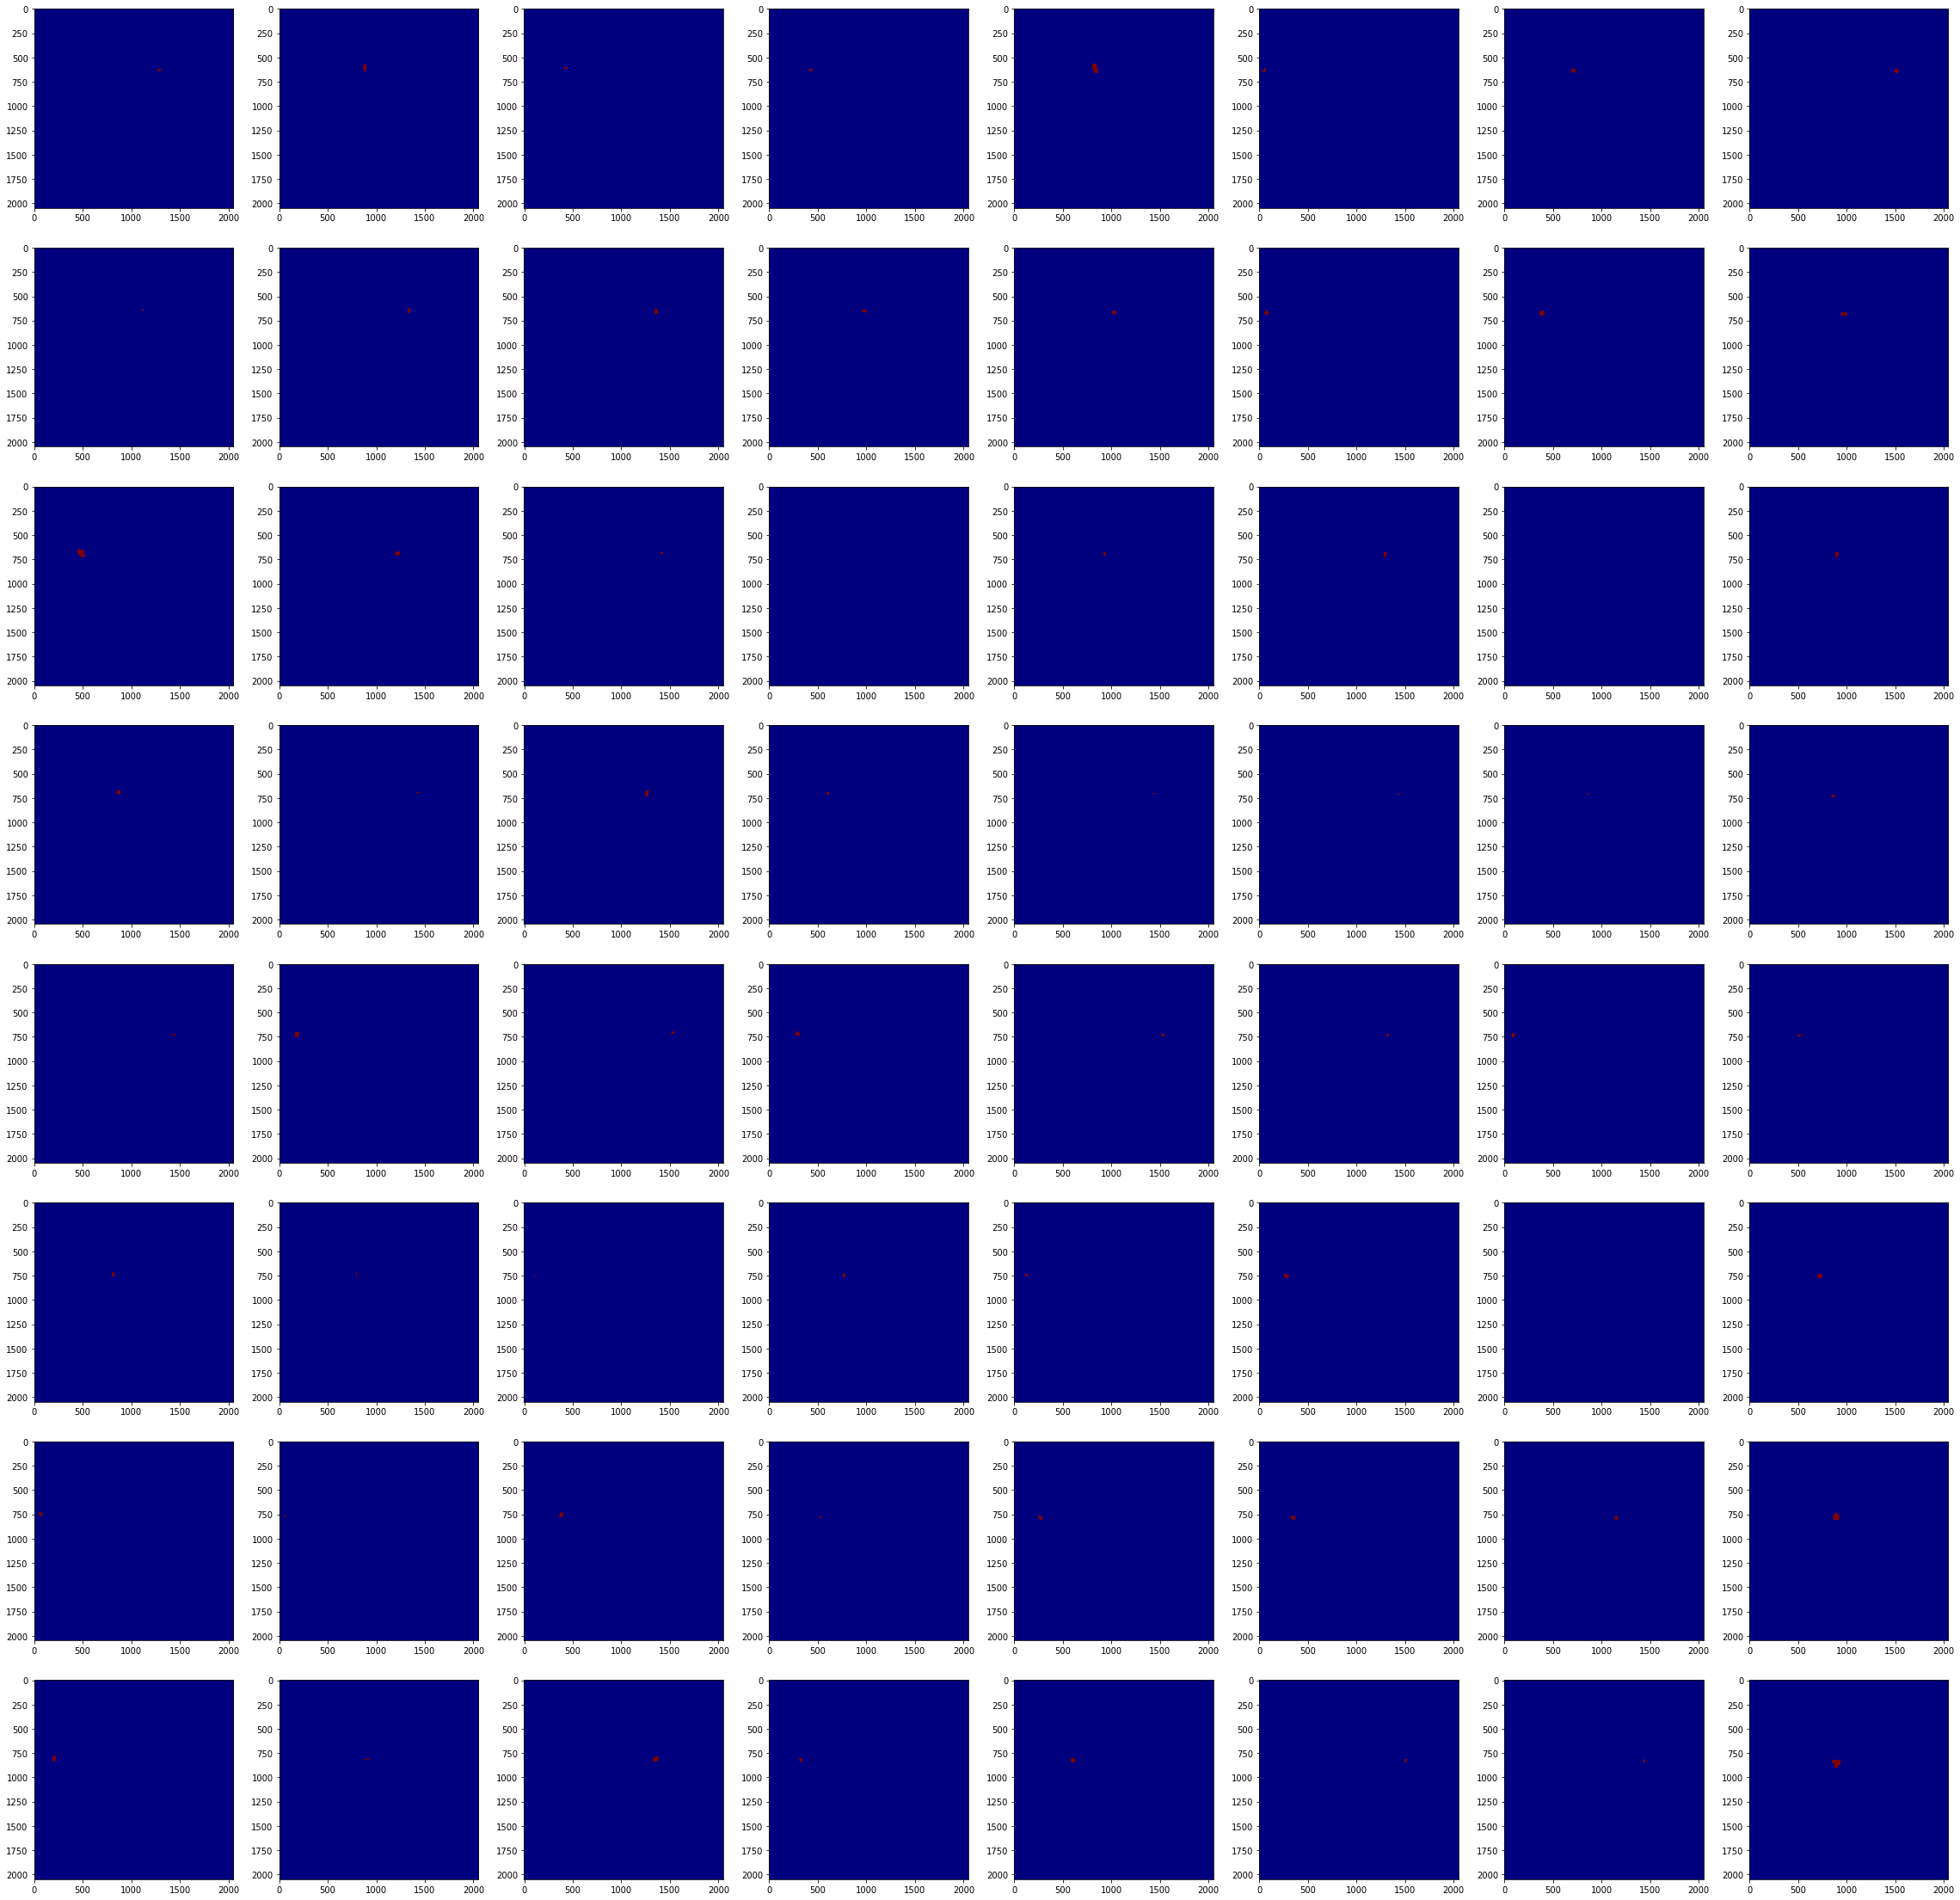

In [474]:
# QC for happiness
Label_sampler(final_labels, num_labels=300)

335


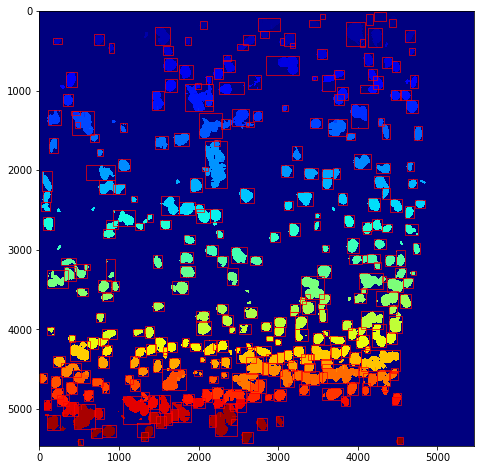

In [100]:
boxes = Label_boxer(final_labels, min_size=2500); print(len(boxes))

<b> Local Nuclear Contrast </b>
<br>Notes to self:
* Option 1: must use original image for <u>nucleii</u> segmentation | Threshold method: Use Binning
* Option 2: use filtered image for <u> whole cell </u> segmentation |  Threshold method: Use minimum

In [41]:
from skimage.filters.rank import enhance_contrast
from skimage.filters import threshold_minimum

In [706]:
target = dna_max   # Option 1: Original for nucleii segment
target = filtered_img   # Option 2: BLurred for whole cell segment
@interact(local_contrast_radius = (1,15,1))
def Local_contrast(local_contrast_radius = 3, aspect_factor = 8, aspect_mode = True):
    enh = enhance_contrast(target, disk(local_contrast_radius))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10),sharex = 'row', sharey = 'row'); ax = axes.ravel()
    
    # find middle
    w, h = target.shape; w_, h_ = w//aspect_factor, h//aspect_factor
    target_ex = target[w_:3*w_, h_:3*h_]; enh_ex = enh[w_:3*w_, h_:3*h_];
    #target_ex = target[700:900, 1100:1200]; enh_ex = enh[700:900, 1100:1200]
    ax[0].imshow(target_ex, cmap=plt.cm.gray); ax[0].set_title('Original')
    ax[1].imshow(enh_ex, cmap=plt.cm.gray); ax[1].set_title('Local morphological contrast enhancement')
    #ax[2].imshow(filtered_img, cmap=plt.cm.gray); ax[3].imshow(enh, cmap=plt.cm.gray); 
    return enh_ex

interactive(children=(IntSlider(value=3, description='local_contrast_radius', max=15, min=1), IntSlider(value=…

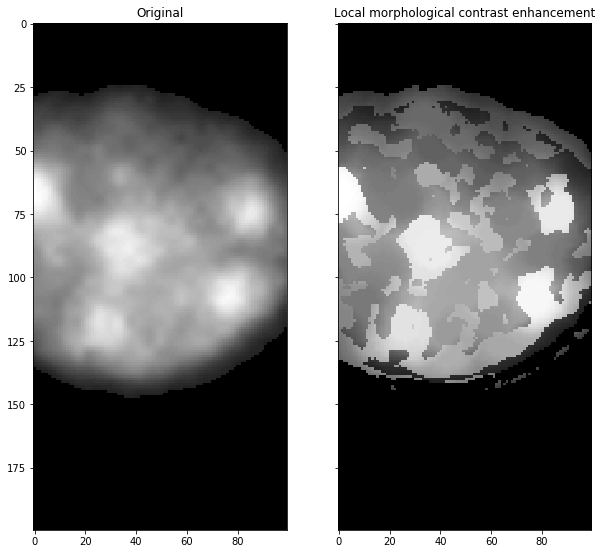

In [649]:
enh_ex = Local_contrast(6)

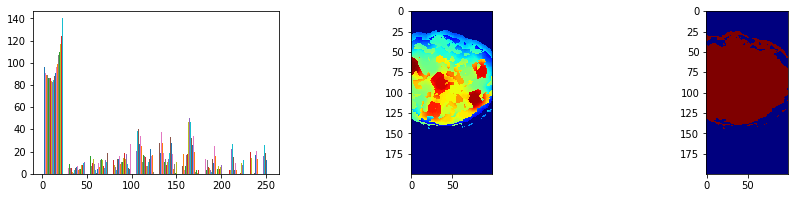

In [650]:
# enhance on a single cell
enh_norm = mh.stretch(enh_ex)
plt.figure(figsize=(15,3))
plt.subplot(131); hist_intensity = plt.hist(enh_norm)
plt.subplot(132); plt.imshow(enh_norm)
# 2 thresholds methods
thres_bin = hist_intensity[-2][-2]; thres_min = threshold_minimum(enh_norm)
plt.subplot(133); plt.imshow(enh_norm > thres_min)

<b> Final Nuclear Labeling

Verify Correct Label (Optional)

(1603, 1100, 1637, 1152) (1603, 1100, 1638, 1153)


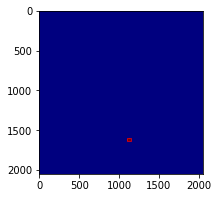

In [519]:
label = 500
nuclei = np.where(final_labels == label); 
print((nuclei[0].min(), nuclei[1].min(), nuclei[0].max(), nuclei[1].max()), boxes[label])
# Plot
x_min, y_min, x_max, y_max = boxes[label]
fig, ax = plt.subplots(1,1)
rect = mpatches.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min,
                                  fill=False, edgecolor='red', linewidth=0.7); ax.add_patch(rect); 
ax.imshow((final_labels==label))

<b> Output Segmentation

In [101]:
from skimage.segmentation import find_boundaries

In [102]:
# Using boxes and local contrasting methods to deliver image of nuclear segments:
def isLabelSurround(surround_img, label):
    for row in surround_img:
        for pixel_label in row:
            if pixel_label == label:
                return True
            else:
                return False
            
def Labeled2Nuclear(img, cell_labels, cell_boxes, method = 'Bin_Thres', local_contrast_radius = 2, output_coords = False):
    img_native = img.copy(); output_coords = {}
    
    if method == 'Bin_Thres':
        bin_nuclear_img = np.full(img.shape, False, dtype= bool)
        for label, box in cell_boxes.items(): # Cell
            (x_min, y_min, x_max, y_max) = box; img_ex = img[x_min:x_max, y_min: y_max]  # Made an image out of bbox
            # Local contrast and bin threshold
            enh_ex = mh.stretch(enhance_contrast(img_ex, disk(local_contrast_radius)))
            hist_intensity = np.histogram(enh_ex); thres_bin = hist_intensity[1][-2]
            coords = np.where(enh_ex > thres_bin);   # print('bbox nuclear', coords, 'bbox', box)
            nuclear_real_coordinates = np.add(coords, np.array([[x_min],[y_min]]))
            bin_nuclear_img[nuclear_real_coordinates[0],nuclear_real_coordinates[1]] = True
        return bin_nuclear_img
    elif method == 'Local_boundary':
        bin_boundary_img = np.full(img.shape, False, dtype= bool)
        for label, box in cell_boxes.items(): # Cell
            (x_min, y_min, x_max, y_max) = box; label_ex = cell_labels[x_min:x_max, y_min: y_max]  # Made an image out of bbox
            boundaries_bin = find_boundaries(label_ex, connectivity=1, mode='thick', background=0)
            coords = np.where(boundaries_bin ==True);
            real_bound_coords = np.add(coords, np.array([[x_min],[y_min]]))
            bin_boundary_img[real_bound_coords[0], real_bound_coords[1]] = True
        return bin_boundary_img
    elif method == 'Show_boundary':
        boundaries_bin = find_boundaries(cell_labels, connectivity=1, mode='thick', background=0)
        return boundaries_bin

In [104]:
# Return binary image of nuclei
#bin_nuclear_img = Labeled2Nuclear(img = dna_max, cell_labels = final_labels, cell_boxes = boxes)
# or
bin_boundary_img = Labeled2Nuclear(img = filtered_img, cell_labels = final_labels, cell_boxes = boxes, method = 'Show_boundary')

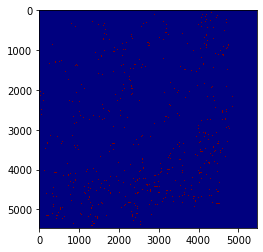

In [105]:
plt.imshow(bin_boundary_img)

# Save a Copy

In [107]:
import PIL.Image as pil

In [108]:
filename = "BK69_Dapi_boundary-2.tif"
im = pil.fromarray(bin_boundary_img); im.save(filename)